### MNIST 이미지 데이터셋

In [10]:
import pandas

In [4]:
df = pandas.read_csv("/home/huni/workspace/GAN_study/DATA/mnist_train.csv", header=None)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


총 6만개의 훈련 이미지

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


### 시각화

In [7]:
import matplotlib.pyplot as plt

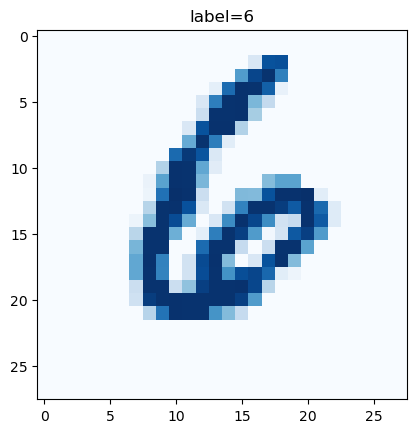

In [9]:
#데이터 할당 
row = 13
data = df.iloc[row]

#레이블 설정
label = data[0]

#이미지값은 나머지 784개의 값
img = data[1:].values.reshape(28,28)
plt.title('label=' + str(label))
plt.imshow(img, interpolation='none',cmap='Blues')
plt.show()


### Dataset

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


In [21]:
# dataset class
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # 정규화 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return값 설정
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass


### Model

In [31]:
class Classifier(nn.Module):
    #초기화
    def __init__(self) :
        super().__init__()
        
        #모델 정의
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 10),
            nn.Sigmoid()
        )

        #손실함수 설정
        self.loss_function = nn.MSELoss()
        #SGD 옵티마이저 설정
        self.optimizer = torch.optim.SGD(self.parameters(), lr = 0.01)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        
        return self.model(inputs)
    
    def train(self, inputs, targets):
        #신경망 출력 계산
        outputs = self.forward(inputs)
    
        loss = self.loss_function(outputs, targets)
        
        #모니터링
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        
        
        #기울기 초기화, 역전파, 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass
    

### Train

In [25]:
mnist_dataset = MnistDataset("/home/huni/workspace/GAN_study/DATA/mnist_train.csv")

In [32]:
%%time 
# create neural network

C = Classifier()

# train network on MNIST data set

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 10min 52s, sys: 16 s, total: 11min 9s
Wall time: 1min 51s


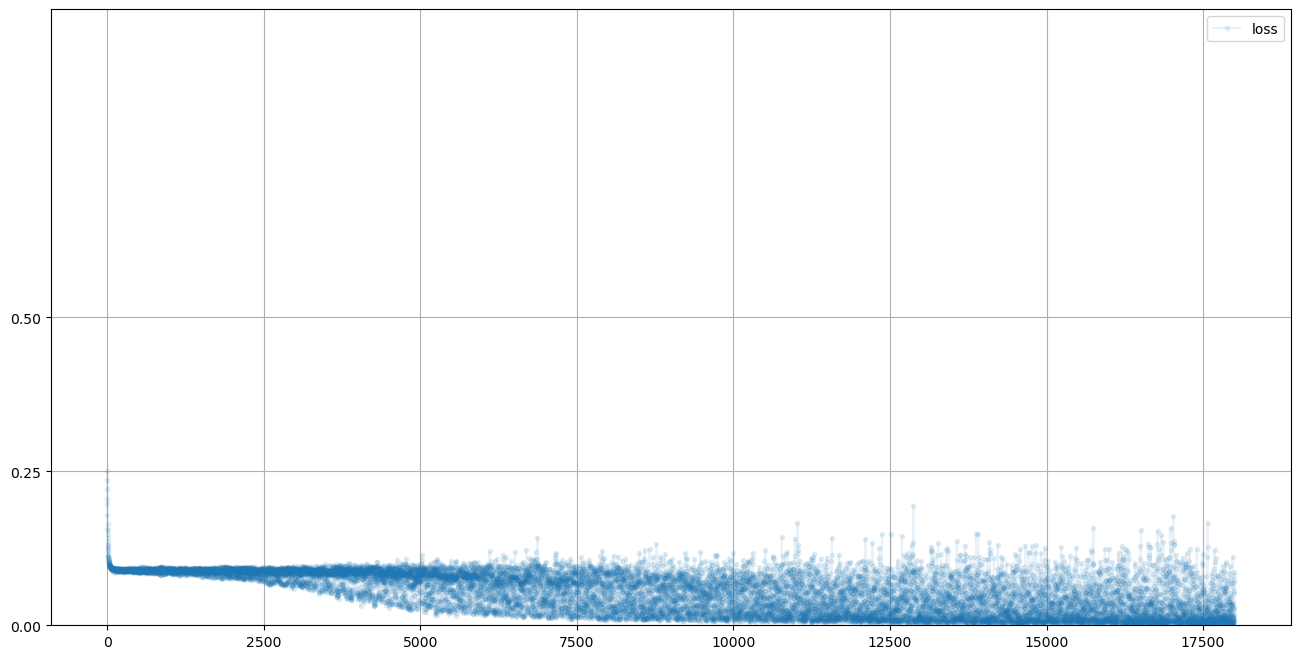

In [33]:
C.plot_progress()

### Test Example

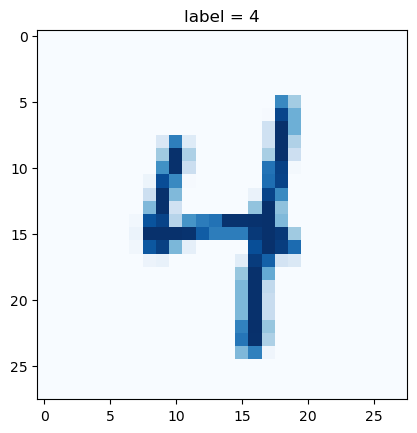

In [35]:
mnist_test = MnistDataset('/home/huni/workspace/GAN_study/DATA/mnist_test.csv')
record = 19

mnist_test.plot_image(record)

<Axes: >

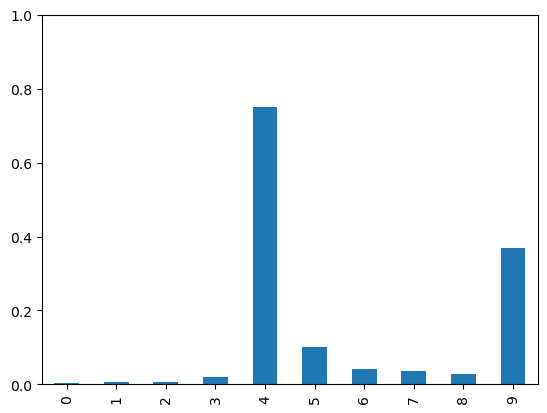

In [37]:
image_sample = mnist_test[record][1]

#추론
output = C.forward(image_sample)

#텐서 
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

### Model Performance

In [38]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

8655 10000 0.8655
